In [1]:
import csv
import re
import html
import csv
import nltk
from csv import writer
from ast import literal_eval
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
#combine N weeks to a single file
def genCombinedFile():
  outputfile = open('combinedFiles.csv', 'w')
  my_file1=open('week2_labelled_tweets2.csv', 'r')
  my_file2=open('week1_labelled_tweets2.csv', 'r')

  for row in my_file1:
        row=row.replace('"', '')
        outputfile.write(row)
  for row in my_file2:
        row=row.replace('"', '')
        outputfile.write(row)

genCombinedFile()

In [3]:
#Load dataframe for test and training data
def ppLoadToDF(file):
  DATASET_COLUMNS=['polarity','tweet_Id','date','text1','text2','text3','text4','text5']
  DATASET_ENCODING = "ISO-8859-1"
  df = pd.read_csv(file, header = None, names=DATASET_COLUMNS, quoting=csv.QUOTE_NONE)
  return df

df = ppLoadToDF('combinedFiles.csv')
df.shape[0]
df.head(5)

polarity             tweet_Id                      date  \
0        0  1462978021288288256  2021-11-23T02:55:15.000Z   
1        0  1462978095439388674  2021-11-23T02:55:33.000Z   
2        0  1462978123247534080  2021-11-23T02:55:40.000Z   
3        1  1462978165878394886  2021-11-23T02:55:50.000Z   
4        1  1462978259759644680  2021-11-23T02:56:12.000Z   

                                               text1  \
0  RT @TheRickyDavila: Since President Biden was ...   
1  @idkMUFC @N09434002 @KhalidAslamSYM @N09434002...   
2  RT @lucyfig513: Can\u2019t believe these last ...   
3  Tune in now to watch Amy continue to rep Oakla...   
4  @halfmarathonman @Jeopardy Millennia of evolut...   

                                               text2 text3 text4 text5  
0   both seditious white supremacists Ted Cruz an...   NaN   NaN   NaN  
1                                                NaN   NaN   NaN   NaN  
2                                                NaN   NaN   NaN   NaN  
3                                                NaN   NaN   NaN   NaN  
4   and you\u2019ve chosen to use all of that to ...   NaN   NaN   NaN

In [4]:
#Load dataframe for any data
def ppAnyLoadToDF(file):
  DATASET_COLUMNS=['tweet_Id','date','text1','text2','text3','text4','text5']
  DATASET_ENCODING = "ISO-8859-1"
  df = pd.read_csv(file, header = None, names=DATASET_COLUMNS, quoting=csv.QUOTE_NONE)
  return df

In [5]:
def ppCombineToFullLen(df):
  #preprocess-combine multiple columns of tweets to full length tweets
  df['fulltweet'] = df['text1'].fillna('').fillna('NaN').map(str) + '' + df['text2'].fillna('').fillna('NaN').map(str) + '' + df['text3'].fillna('').fillna('NaN').map(str)+ ''+ df['text4'].fillna('').fillna('NaN').map(str)+ '' + df['text5'].fillna('').fillna('NaN').map(str)
  #dropping multiple columns of tweets after combining into fulltweet
  df.drop(['text1','text2','text3','text4','text5'], axis=1, inplace=True)
  df.sample(5)
  return df

df = ppCombineToFullLen(df)
df.sample(5)

polarity             tweet_Id                      date  \
2065        0  1459360872564871171  2021-11-13T03:22:00.000Z   
1480        0  1459359116577718272  2021-11-13T03:15:01.000Z   
391         1  1463706319538438146  2021-11-25T03:09:15.000Z   
1111        0  1459361691834073093  2021-11-13T03:25:15.000Z   
1485        0  1459359170587619330  2021-11-13T03:15:14.000Z   

                                              fulltweet  
2065  @6000Lights @levarburton @watersforfish @Jeopa...  
1480  RT @levarburton: You can keep my name out of @...  
391                   JSOPDRDPS https://t.co/O7wLtWcUAI  
1111  RT @levarburton: You can keep my name out of @...  
1485  RT @khine_myak: Being a part of #CDM of #myanm...

# Analytics and Preparing Data

In [6]:
def ppAddPreLen(df):
  df['pre_length'] = df['fulltweet'].apply(lambda x: len(x))

ppAddPreLen(df)

In [7]:
#check data types
print(df.dtypes)
print(df[df['polarity'].isnull()])

polarity      object
tweet_Id       int64
date          object
fulltweet     object
pre_length     int64
dtype: object
Empty DataFrame
Columns: [polarity, tweet_Id, date, fulltweet, pre_length]
Index: []


In [8]:
#convert polarity to integer
def convertPolToInt(df):
  df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce')
  df = df.dropna(subset=['polarity'])
  df['polarity'] = df['polarity'].astype(int)

convertPolToInt(df)


/var/folders/8n/zflmpvxs6w5_xbzk0jvfnxqx2qxtfk/T/ipykernel_23185/1821671517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = df['polarity'].astype(int)


In [9]:
df['polarity'].value_counts()

0.0    1311
1.0     918
Name: polarity, dtype: int64

/Users/c-ksood/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pre_length', ylabel='Density'>

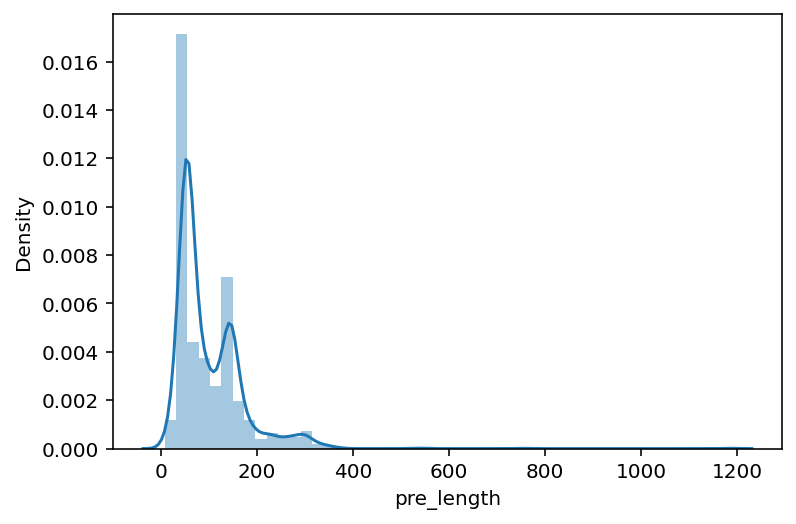

In [10]:
sns.distplot(df['pre_length'])

<AxesSubplot:ylabel='pre_length'>

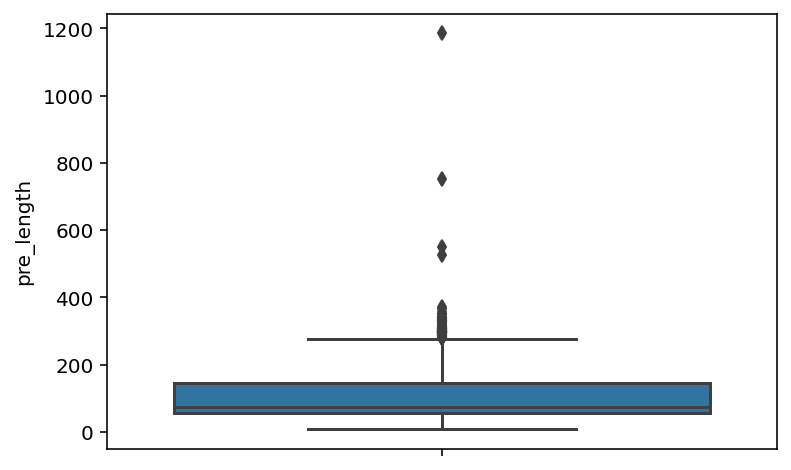

In [11]:
sns.boxplot(y='pre_length', data=df)

In [12]:
df[df['pre_length']>400]

polarity             tweet_Id                      date  \
61        0.0  1462983822492983301  2021-11-23T03:18:18.000Z   
70        0.0  1462984374266343427  2021-11-23T03:20:30.000Z   
485       0.0  1464066445306998796  2021-11-26T03:00:16.000Z   
487       0.0  1464066535052484608  2021-11-26T03:00:37.000Z   

                                             fulltweet  pre_length  
61   @DannaAMPond @MatPatGT @CordyPatrick @dawkosga...         526  
70   @DannaAMPond @MatPatGT @CordyPatrick @dawkosga...         753  
485  https://t.co/IZJAJ1hwir\n\n\u0633\u0628\u062d\...        1185  
487  RT @jamaloman: https://t.co/IZJAJ1hwir\n\n\u06...         549

There are few that more than 400 characters long. We need to clean the data.

Text(0.5, 0.98, 'Length via each Sentiment')

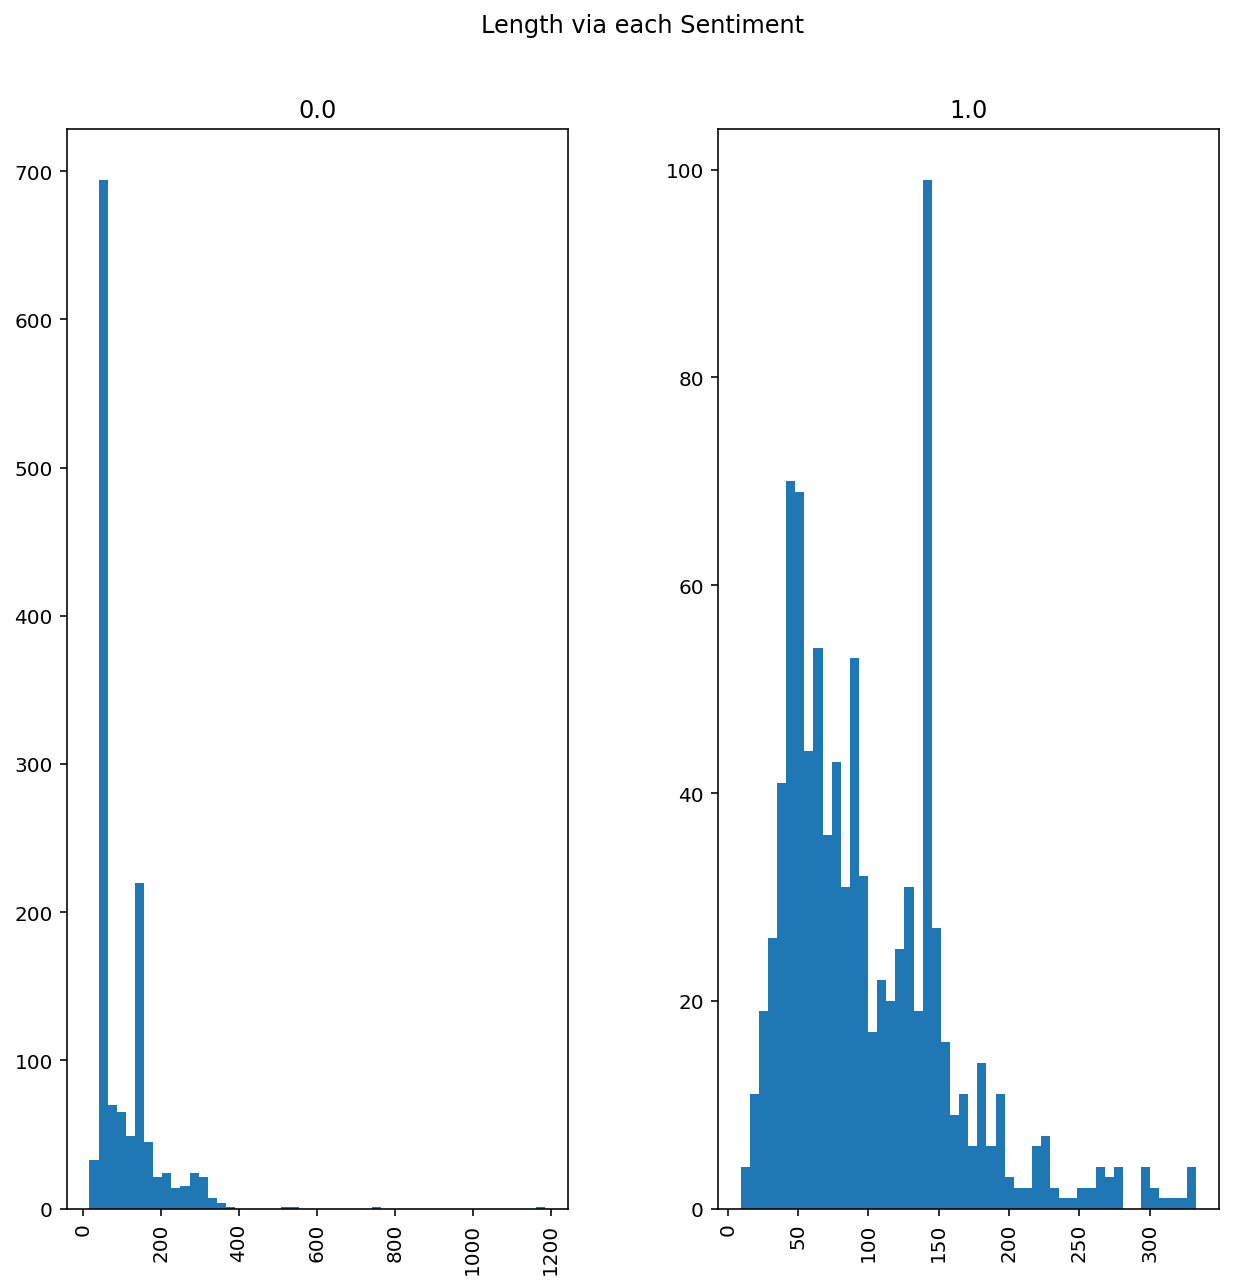

In [13]:
ax = df.hist(column = 'pre_length', by = 'polarity', bins = 50 , figsize = (10,10));
pl.suptitle('Length via each Sentiment') 

From these plots you can see that there are a lot of negative reviews that have lengths greater than 100.

In [14]:
data_positive = df[df['polarity'] == 1]
data_negative = df[df['polarity'] == 0]

In [15]:
dataset = pd.concat([data_positive, data_negative])
dataset.head()

polarity             tweet_Id                      date  \
3       1.0  1462978165878394886  2021-11-23T02:55:50.000Z   
4       1.0  1462978259759644680  2021-11-23T02:56:12.000Z   
5       1.0  1462978417138225157  2021-11-23T02:56:50.000Z   
6       1.0  1462978492887277580  2021-11-23T02:57:08.000Z   
7       1.0  1462978509819756549  2021-11-23T02:57:12.000Z   

                                           fulltweet  pre_length  
3  Tune in now to watch Amy continue to rep Oakla...          95  
4  @halfmarathonman @Jeopardy Millennia of evolut...         256  
5  The latest My Playful News! https://t.co/n9Lig...          95  
6  if i were on jeopardy and didn\u2019t make it ...          94  
7  @AmodioMatt Thanks for replying Jeopardy champ...          55

In [16]:
data_positive = df[df['polarity'] == 1]
data_negative = df[df['polarity'] == 0]

dataset = pd.concat([data_positive, data_negative])

# Start data cleaning

In [17]:
#Removing punctuations
def ppRemovePunct(df):
  import string
  english_punctuations = string.punctuation
  punctuations_list = english_punctuations

  def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

  df['fulltweet']= dataset['fulltweet'].apply(lambda x: cleaning_punctuations(x))
  df['fulltweet'].tail()

  return dataset

df = ppRemovePunct(df)
df.head()

polarity             tweet_Id                      date  \
3       1.0  1462978165878394886  2021-11-23T02:55:50.000Z   
4       1.0  1462978259759644680  2021-11-23T02:56:12.000Z   
5       1.0  1462978417138225157  2021-11-23T02:56:50.000Z   
6       1.0  1462978492887277580  2021-11-23T02:57:08.000Z   
7       1.0  1462978509819756549  2021-11-23T02:57:12.000Z   

                                           fulltweet  pre_length  
3  Tune in now to watch Amy continue to rep Oakla...          95  
4  @halfmarathonman @Jeopardy Millennia of evolut...         256  
5  The latest My Playful News! https://t.co/n9Lig...          95  
6  if i were on jeopardy and didn\u2019t make it ...          94  
7  @AmodioMatt Thanks for replying Jeopardy champ...          55

# HTML Decoding

In [18]:
df['fulltweet'][705]

'@Jeopardy why did the lady not also get $2000 in tonight\\u2019s episode? She &amp; he were tied. Why?'

# URLs

In [19]:
df['fulltweet'][36]

'Final Jeopardy !: \\u201c20TH CENTURY PRESIDENTS\\u201d (22/11/21) | DANGER! \\u2013\\xa0Danger! https://t.co/FVXTFqg5Pc'

# Mentions

In [20]:
df['fulltweet'][704]

'Six weeks\\u2019 worth of @Jeopardy wins to go for @Jeopardamy to catch @AmodioMatt \\u2014 I wanna see her do it. She\\u2019s got the knowledge instinct and the speed!'

# Hashtags

In [21]:
df['fulltweet'][719]

"RT @WIONews: #India's cricket tour in jeopardy as South Africa likely to suspend all sports due to new COVID-19 variant\\n\\n#OmicronVariant #C\\u2026"

# Data Cleaning

In [22]:
from nltk.tokenize import TreebankWordTokenizer

In [23]:
token = TreebankWordTokenizer()

In [24]:
def ppAllCleanTweets(df):
  nltk.download('wordnet')
  mentions = r'@[A-Za-z0-9]+'
  url_https = 'https?://[A-Za-z0-9./]+'
  url_www = r'www.[^ ]+'

  negations = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
             "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
             "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
             "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
             "mustn't":"must not"
            }

  stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves','jeopardy','rt']

  def tweet_cleaning(fulltweet):
    fulltweet = html.unescape(fulltweet)
    fulltweet = re.sub(mentions, '', fulltweet)
    fulltweet = re.sub(url_https, '', fulltweet)
    tefulltweetxt = re.sub(url_www, '', fulltweet)
    fulltweet = fulltweet.lower()
    for a, b in negations.items():
        if a in fulltweet:
            fulltweet = fulltweet.replace(a,b)
    #Removing characters except letters
    fulltweet = re.sub("[^a-zA-Z]", " ", fulltweet)
    #Removing unnecessary white spaces using tokenizer
    word_list = token.tokenize(fulltweet)
    fulltweet = " ".join(word_list).strip()
    return fulltweet
  
  df['fulltweet'] = df['fulltweet'].apply(lambda x: tweet_cleaning(x)) 
  
  #removing stopwords
  STOPWORDS = set(stopwordlist)
  def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
  
  df['fulltweet'] = df['fulltweet'].apply(lambda x: cleaning_stopwords(x))
  
  #stemming- Stemming refers to the process of normalization, 
  #where we reduce a word to its base stem, for example, “automate”, “automatic”, “automation,” “automations” 
  #will be reduced to “automat” such that all these forms refer to automat.
  st = nltk.PorterStemmer()
  def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
  df['fulltweet']= df['fulltweet'].apply(lambda x: stemming_on_text(x))
  
  #lemmatize- Lemmatization on the other hand usually refers to doing things properly 
  #with the use of a vocabulary and morphological analysis, normally aiming to remove 
  #inflectional endings only and to return the dictionary form of a word.
  lm = nltk.WordNetLemmatizer()
  def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
  df['fulltweet'] = df['fulltweet'].apply(lambda x: lemmatizer_on_text(x))
  print('cleaned tweets-removed urls,mentions,hashtags,negations,stopwords,lemmatized data, stemming done!')

ppAllCleanTweets(df)
df['fulltweet'].head()

[nltk_data] Downloading package wordnet to /Users/c-ksood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


cleaned tweets-removed urls,mentions,hashtags,negations,stopwords,lemmatized data, stemming done!


3             tune watch amy continue rep oakland week
4    millennia evolution technological development ...
5      latest playful news thanks thejeopardyfan funko
6              didn u make final absolutely would kill
7                        thanks replying champion matt
Name: fulltweet, dtype: object

In [25]:
df.drop(['pre_length'], axis=1, inplace=True)

In [26]:
df.head()

polarity             tweet_Id                      date  \
3       1.0  1462978165878394886  2021-11-23T02:55:50.000Z   
4       1.0  1462978259759644680  2021-11-23T02:56:12.000Z   
5       1.0  1462978417138225157  2021-11-23T02:56:50.000Z   
6       1.0  1462978492887277580  2021-11-23T02:57:08.000Z   
7       1.0  1462978509819756549  2021-11-23T02:57:12.000Z   

                                           fulltweet  
3           tune watch amy continue rep oakland week  
4  millennia evolution technological development ...  
5    latest playful news thanks thejeopardyfan funko  
6            didn u make final absolutely would kill  
7                      thanks replying champion matt

In [27]:
df.to_csv('preprocessed_tweets_combined.csv', encoding='utf-8')

In [28]:
def plotNegativeCloud(df, term_used):
    negative_tweets = df[df[term_used]== 0]
    neg_tweet = []
    for tweet in negative_tweets.fulltweet:
        neg_tweet.append(tweet)
    neg_tweet = pd.Series(neg_tweet).str.cat(sep = ' ')

    neg_wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_tweet)
    plt.figure(figsize=(12,10))
    plt.imshow(neg_wordcloud, interpolation="bilinear")
    plt.axis("off")
    print('plot word cloud of Negative tweets')
    plt.show()

In [29]:
def plotPositiveCloud(df, term_used):
    positive_tweets = df[df[term_used]== 1]

    pos_tweet = []
    for tweet in positive_tweets.fulltweet:
        pos_tweet.append(tweet)
    pos_tweet = pd.Series(pos_tweet).str.cat(sep = ' ')

    pos_wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_tweet)
    plt.figure(figsize=(12,10))
    plt.imshow(pos_wordcloud, interpolation="bilinear")
    plt.axis("off")
    print('plot word cloud of Positive tweets')
    plt.show()

plot word cloud of Negative tweets


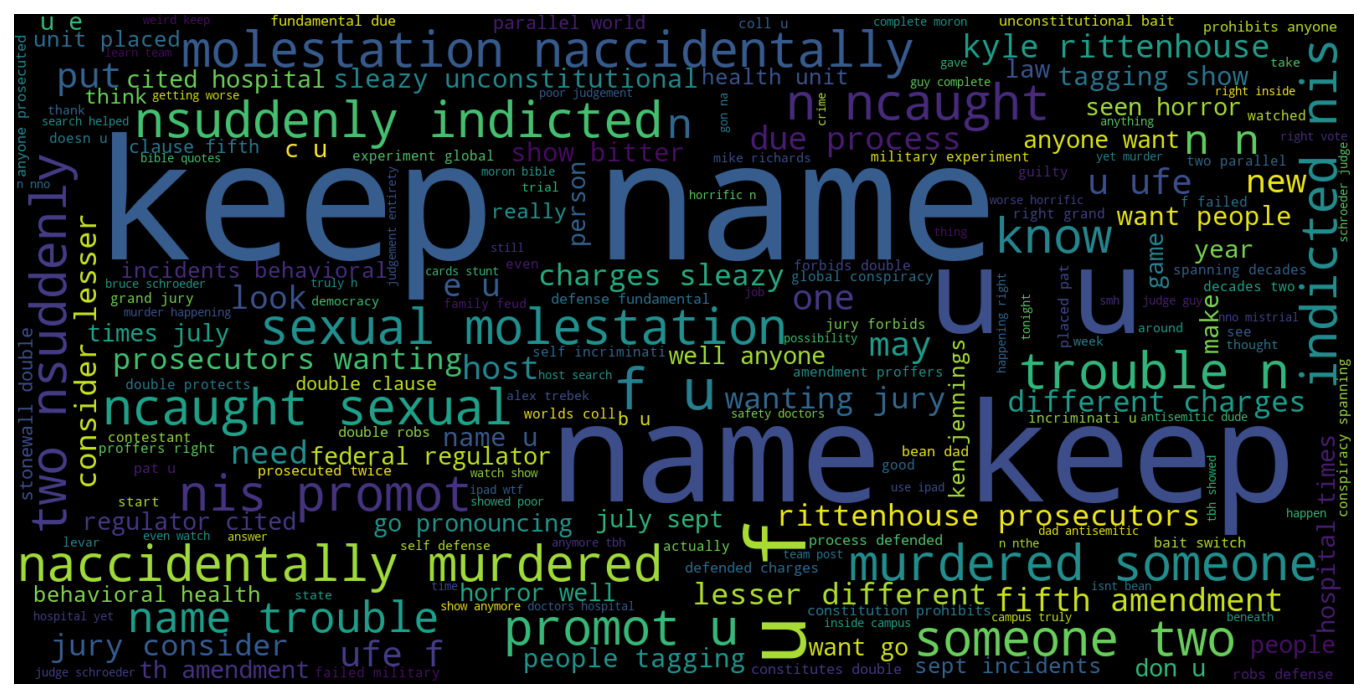

plot word cloud of Positive tweets


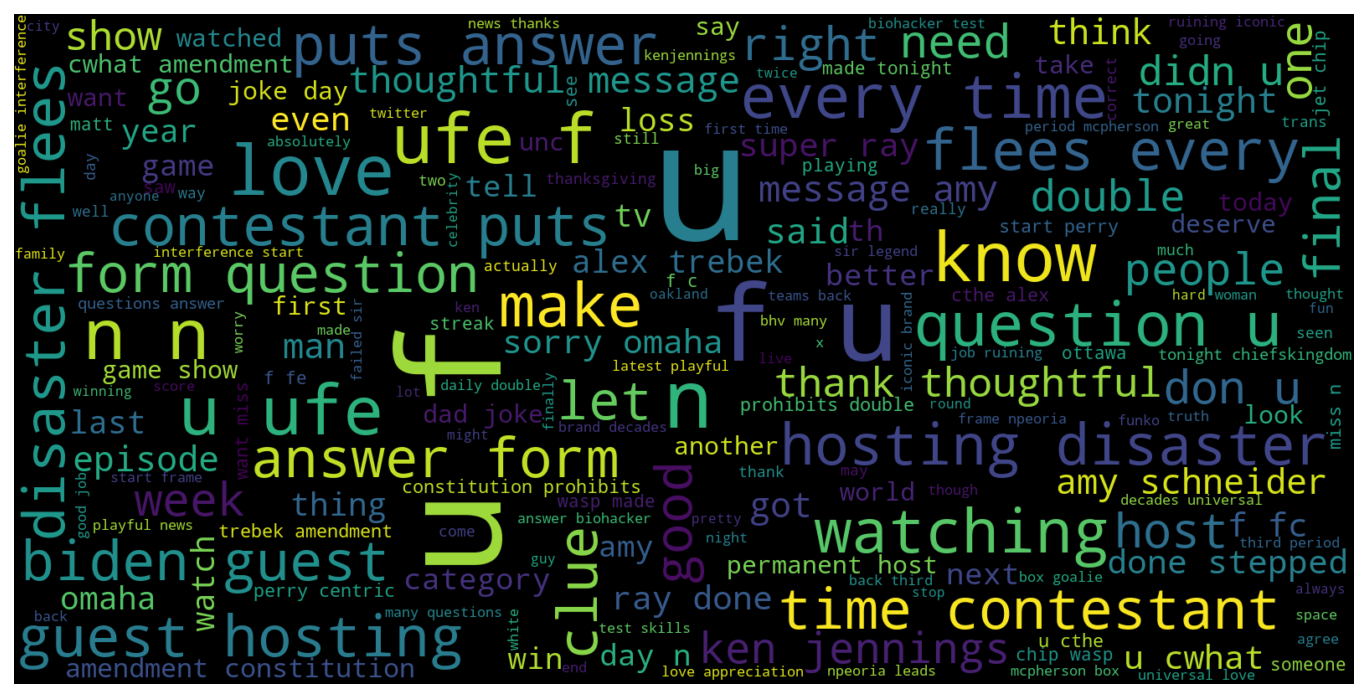

In [30]:
#creating word cloud
plotNegativeCloud(df, 'polarity')
plotPositiveCloud(df, 'polarity')

# Train a model

In [31]:
def drop_unnamed(df):
    df.drop(['Unnamed: 0'], axis=1, inplace = True)
    df.describe()
    df.info()

def drop_na(df) :
    df.dropna(inplace=True)
    df.info()

#drop_unnamed(df)
df[df['fulltweet'].isnull()].count()
drop_na(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 3 to 2229
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   polarity   2229 non-null   float64
 1   tweet_Id   2229 non-null   int64  
 2   date       2229 non-null   object 
 3   fulltweet  2229 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 87.1+ KB


              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       130
         1.0       0.77      0.80      0.78        93

    accuracy                           0.82       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223

Accuracy Score of Naive Bayes: 0.8161434977578476


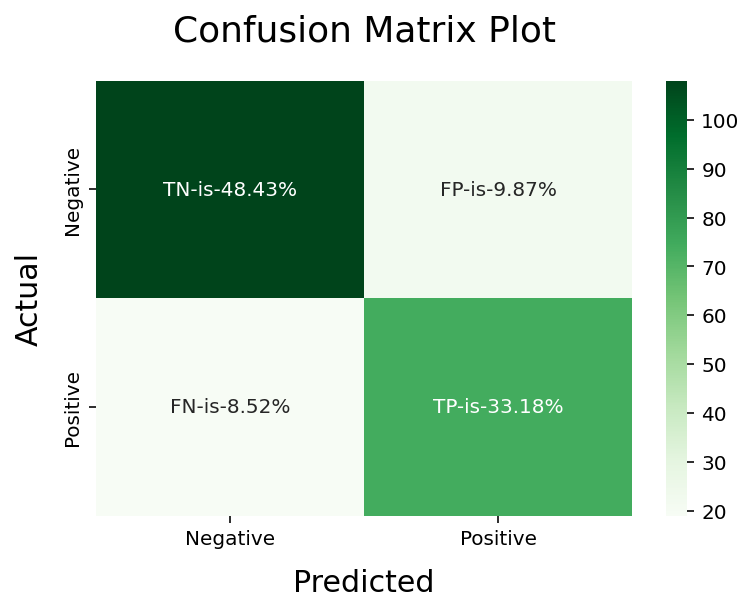

In [32]:
def split_into_training(X,y):
    # Splitting around the 90% data for training and 10% for testing
    return (train_test_split(X,y,test_size = 0.10, random_state =222900))

def evaluate_model_values(model):
# Predict values for Test dataset
    y_pred = model.predict(X_testing)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_testing, y_pred))
    confusion_matrix_plot(y_pred)

# Computation of Confusion matrix
def confusion_matrix_plot(y_pred):
    confusion_matrix_plot = confusion_matrix(y_testing, y_pred)
    categories = ['Negative','Positive']
    matrix_group_names = ['TN','FP', 'FN','TP']
    matrix_group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix_plot.flatten() / np.sum(confusion_matrix_plot)]
    labels = [f'{v1}-is-{v2}' for v1, v2 in zip( matrix_group_names,matrix_group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix_plot, annot = labels, cmap = 'Greens',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted", fontdict = {'size':15}, labelpad = 10)
    plt.ylabel("Actual" , fontdict = {'size':15}, labelpad = 10)
    plt.title ("Confusion Matrix Plot", fontdict = {'size':18}, pad = 20)

X=df.fulltweet
y=df.polarity
X_training, X_testing, y_training, y_testing = split_into_training(X,y)

vectorize_train_test = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorize_train_test.fit(X_training)
X_training = vectorize_train_test.transform(X_training)
X_testing  = vectorize_train_test.transform(X_testing)

# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_training, y_training)
evaluate_model_values(NB_model)
y_predict1 = NB_model.predict(X_testing)
print('Accuracy Score of Naive Bayes:',accuracy_score(y_testing, y_predict1))

              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86       130
         1.0       0.77      0.91      0.83        93

    accuracy                           0.85       223
   macro avg       0.85      0.86      0.85       223
weighted avg       0.86      0.85      0.85       223

Accuracy Score of LogisticRegression: 0.8475336322869955


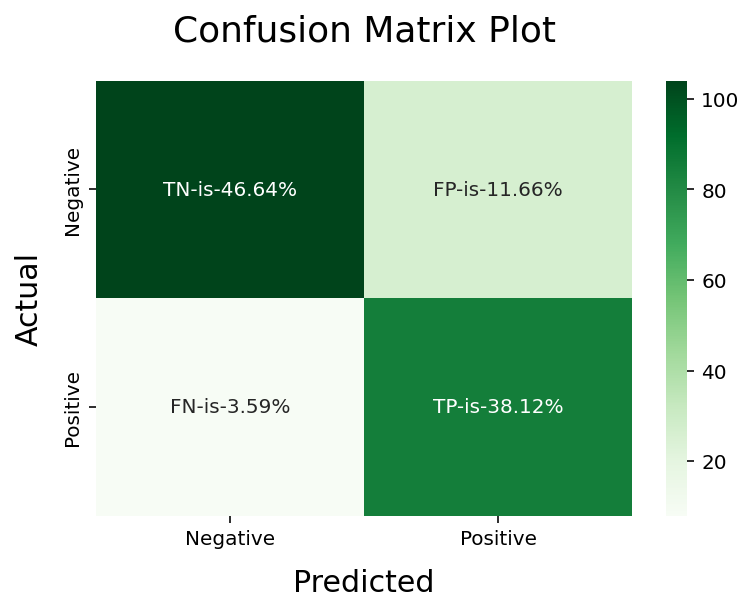

In [33]:
# Training Logistic Regression model
LogisticR_model = LogisticRegression(solver='lbfgs')
LogisticR_model.fit(X_training, y_training)
evaluate_model_values(LogisticR_model)
y_predict2 = LogisticR_model.predict(X_testing)
print('Accuracy Score of LogisticRegression:',accuracy_score(y_testing, y_predict2))

Above confusion matrix shows Naive Bayes model with 80% accuracy and Logistic Regression model with 82% accuracy

# Predictions for given a file using above trained models

In [34]:
my_file_predict=open('../data/Jeopardy_2021_12_04', 'r')

In [35]:
new_df = ppAnyLoadToDF(my_file_predict)
new_df.shape[0]

157

In [36]:
ppCombineToFullLen(new_df)
new_df.sample(5)

tweet_Id                      date  \
44   1466967414873153542  2021-12-04T03:07:41.000Z   
105  1466971968263970818  2021-12-04T03:25:46.000Z   
57   1466968505199120385  2021-12-04T03:12:01.000Z   
47   1466967630854561797  2021-12-04T03:08:32.000Z   
82   1466970539692539904  2021-12-04T03:20:06.000Z   

                                             fulltweet  
44   RT @RadioFreeTom: Jeopardy proving again that ...  
105  RT @hotairblog: Here's why current 'Jeopardy!'...  
57   Stephen A. Smith says Frank Vogel's future in ...  
47   RT @NazrudinRahman: Omicron is here. KKM alrea...  
82   "Why are you watching Jeopardy?"\n\n"Sheldon's...

In [37]:
ppAddPreLen(new_df)
new_df.sample(5)

tweet_Id                      date  \
19   1466965826377027584  2021-12-04T03:01:22.000Z   
4    1466964543666630658  2021-12-04T02:56:16.000Z   
23   1466965999614263296  2021-12-04T03:02:03.000Z   
52   1466968118077628421  2021-12-04T03:10:28.000Z   
112  1466972479893557252  2021-12-04T03:27:48.000Z   

                                             fulltweet  pre_length  
19   RT @ErinInTheMorn: Amy Schneider breaks $500k ...         145  
4    RT @CNN: "Jeopardy!" champion Amy Schneider is...         145  
23   Hey football you are messing with my #Jeopardy...          88  
52   RT @ErinInTheMorn: Amy Schneider breaks $500k ...         145  
112  RT @NazrudinRahman: Omicron is here. KKM alrea...         146

In [38]:
#Remove punctuations in new file
ppRemovePunct(new_df)

polarity             tweet_Id                      date  \
3          1.0  1462978165878394886  2021-11-23T02:55:50.000Z   
4          1.0  1462978259759644680  2021-11-23T02:56:12.000Z   
5          1.0  1462978417138225157  2021-11-23T02:56:50.000Z   
6          1.0  1462978492887277580  2021-11-23T02:57:08.000Z   
7          1.0  1462978509819756549  2021-11-23T02:57:12.000Z   
...        ...                  ...                       ...   
2224       0.0  1459363908624556033  2021-11-13T03:34:04.000Z   
2226       0.0  1459363935317110793  2021-11-13T03:34:10.000Z   
2227       0.0  1459363992984383490  2021-11-13T03:34:24.000Z   
2228       0.0  1459364126074060805  2021-11-13T03:34:55.000Z   
2229       0.0  1459364140045066241  2021-11-13T03:34:59.000Z   

                                              fulltweet  
3              tune watch amy continue rep oakland week  
4     millennia evolution technological development ...  
5       latest playful news thanks thejeopardyfan funko  
6               didn u make final absolutely would kill  
7                         thanks replying champion matt  
...                                                 ...  
2224                                          keep name  
2226                                          keep name  
2227  trouble n ncaught sexual molestation naccident...  
2228                                          keep name  
2229                    much ur boobs weigh music plays  

[2229 rows x 4 columns]

In [39]:
#Clean data in new file
ppAllCleanTweets(new_df)
new_df.sample(5)

cleaned tweets-removed urls,mentions,hashtags,negations,stopwords,lemmatized data, stemming done!


[nltk_data] Downloading package wordnet to /Users/c-ksood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tweet_Id                      date  \
133  1466973535931351050  2021-12-04T03:32:00.000Z   
81   1466970538358849539  2021-12-04T03:20:05.000Z   
146  1466973799459393538  2021-12-04T03:33:03.000Z   
126  1466973185723838465  2021-12-04T03:30:37.000Z   
77   1466970224704438272  2021-12-04T03:18:51.000Z   

                                             fulltweet  pre_length  
133  said u say true life goal absolutely eat shit ...         119  
81                                     see hanks black          73  
146  strong words correct responses yelled tv tonig...         145  
126           jet chip wasp made tonight chiefskingdom          66  
77   none contestants recognized grace kelly u got ...          93

In [40]:
X_new_file_tweet=new_df.fulltweet

In [42]:
#is  = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorize_train_test.fit(X_new_file_tweet)
X_new_file_tweet = vectorize_train_test.transform(X_new_file_tweet)

In [43]:
#predict using Naive Bayes Model
new_df['sentiment_pred'] = NB_model.predict(X_new_file_tweet)

In [44]:
#predict using Logistic Regression Model
new_df['sentiment_pred_LR'] = LogisticR_model.predict(X_new_file_tweet)

In [45]:
#show predicted values on both models in dataframe
new_df[new_df['pre_length']>200]

tweet_Id                      date  \
1    1466964411726315523  2021-12-04T02:55:45.000Z   
13   1466965404752891905  2021-12-04T02:59:42.000Z   
15   1466965518410080256  2021-12-04T03:00:09.000Z   
25   1466966010758635529  2021-12-04T03:02:06.000Z   
28   1466966407170695170  2021-12-04T03:03:41.000Z   
33   1466966816538853378  2021-12-04T03:05:18.000Z   
36   1466966906796134403  2021-12-04T03:05:40.000Z   
46   1466967533261668355  2021-12-04T03:08:09.000Z   
48   1466967846257405956  2021-12-04T03:09:24.000Z   
53   1466968128575852546  2021-12-04T03:10:31.000Z   
69   1466969600487157762  2021-12-04T03:16:22.000Z   
73   1466969841324154890  2021-12-04T03:17:19.000Z   
93   1466971105646764032  2021-12-04T03:22:21.000Z   
94   1466971182423547905  2021-12-04T03:22:39.000Z   
100  1466971365584654337  2021-12-04T03:23:23.000Z   
155  1466974208077213703  2021-12-04T03:34:40.000Z   

                                             fulltweet  pre_length  \
1    believes bd u test status isn u questionable i...         214   
13                        warmington freedom canadians         288   
15   watching x amy schneider heidi stumb mack hayd...         277   
25   oh not worry occasional stray transphobic comm...         205   
28                                               u man         211   
33   almost thought pumpkin pie u f no evaporated m...         251   
36   final u c th century presidents u danger u xa ...         242   
46   first place losing week beat brother wasn u ev...         245   
48                 buat kamuflase di antara rerumputan         287   
53   keep clinging year old super bowl win u got ev...         226   
69                joke answers score double every time         236   
73   ohhh oh oh question u answer u cwhat happens s...         300   
93                           ikr no need apologize u f         246   
94   looks like seminole tribe u monopoly sports be...         306   
100           tune watch amy continue rep oakland week         273   
155                                                            324   

     sentiment_pred  sentiment_pred_LR  
1               1.0                1.0  
13              1.0                1.0  
15              1.0                1.0  
25              0.0                0.0  
28              1.0                1.0  
33              1.0                1.0  
36              1.0                1.0  
46              1.0                1.0  
48              0.0                1.0  
53              0.0                0.0  
69              1.0                1.0  
73              0.0                0.0  
93              1.0                1.0  
94              0.0                0.0  
100             1.0                0.0  
155             0.0                1.0

plot word cloud of Negative tweets


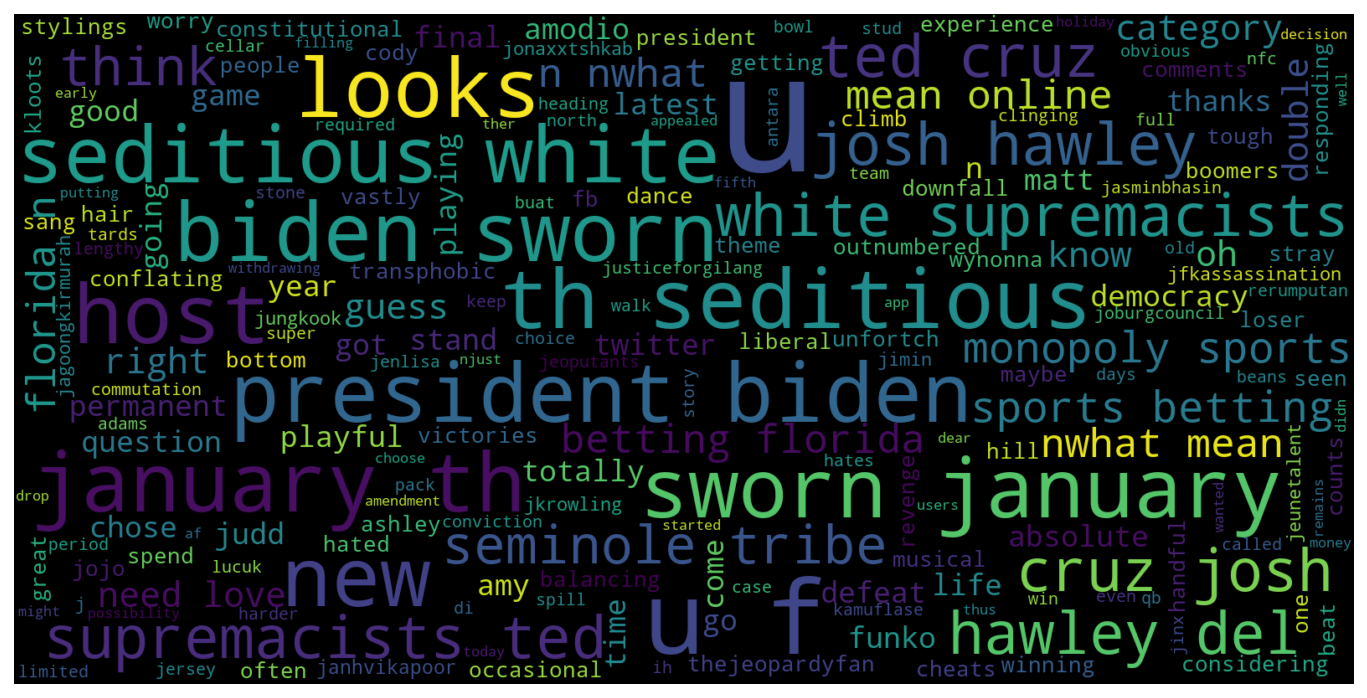

plot word cloud of Negative tweets


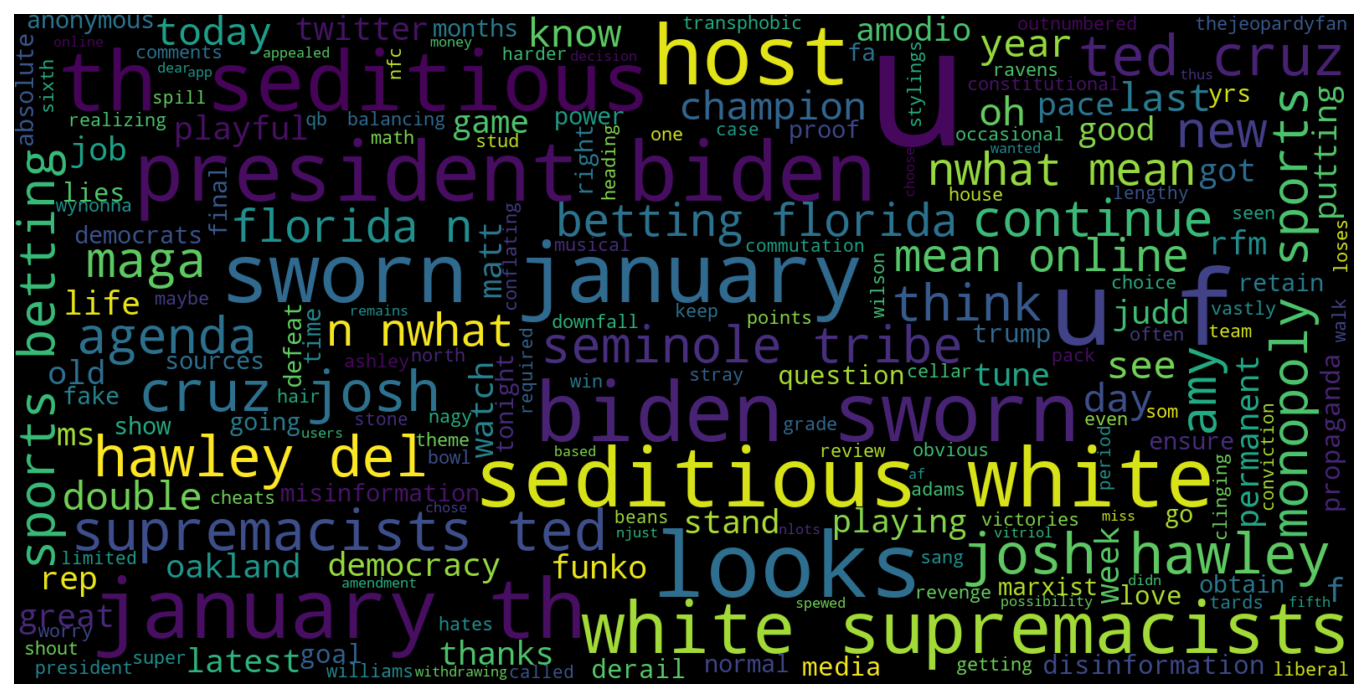

In [46]:
#creating word cloud
plotNegativeCloud(new_df, 'sentiment_pred')
plotNegativeCloud(new_df, 'sentiment_pred_LR')

plot word cloud of Positive tweets


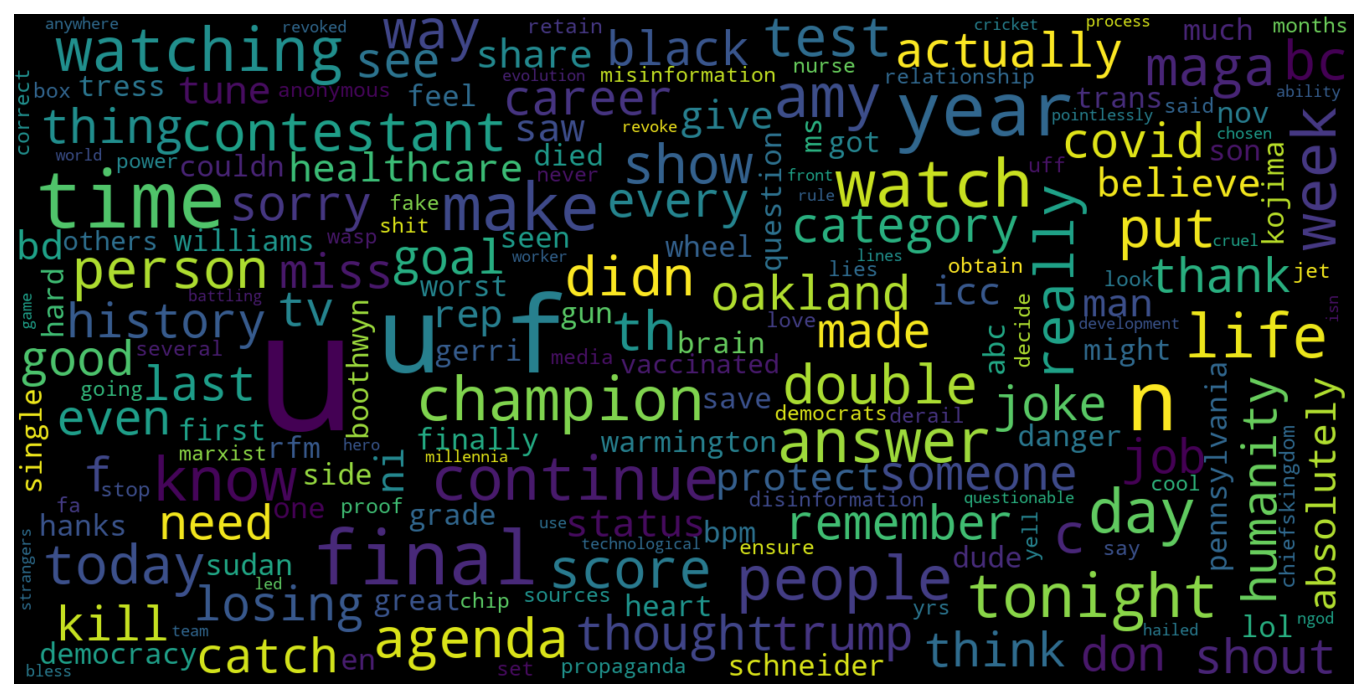

plot word cloud of Positive tweets


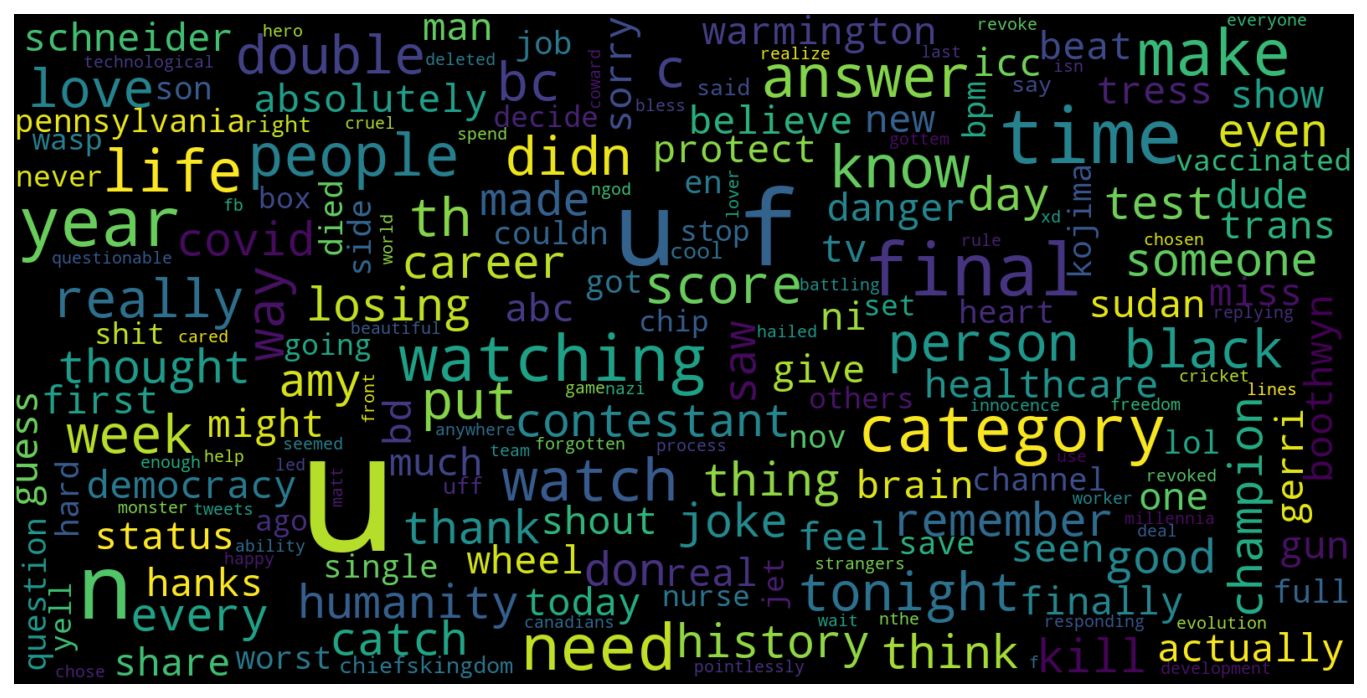

In [47]:
#creating word cloud
plotPositiveCloud(new_df, 'sentiment_pred')
plotPositiveCloud(new_df, 'sentiment_pred_LR')

In [50]:
from joblib import dump, load
dump(NB_model, 'NB_model.joblib') 
dump(LogisticR_model, 'LogisticR_model.joblib')
dump(vectorize_train_test, 'vectorizer.joblib')

['vectorizer.joblib']